Qualitative Gaussian Blob Tests
==

This notebook runs a single gaussian blob test case in several DWAQ-formatted
hydrodynamic datasets, and generates a summary figure for each.

It does not try to adjust the blobs (as in using a coarse representation of the
blob even when using a fine-resolution grid).

The runs are in 3D, but the results are just plotted for the surface layer.


In [45]:
# Quiet some of the logging
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='WARN'
import logging
logging.getLogger().setLevel(logging.WARNING)
log = logging.getLogger()
log.debug('Test debug')

ERROR:root:The 'log_level' trait of an IPKernelApp instance must be any of (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL'), but a value of 'WORKAROUND' <class 'str'> was specified.


In [49]:
import matplotlib.pyplot as plt
from shapely import geometry, wkt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import stompy.model.delft.waq_scenario as dwaq
import logging as log
from stompy import utils
from stompy.plot import plot_wkb
import os
import six
from matplotlib import gridspec
#%matplotlib notebook
%matplotlib inline

In [70]:
cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

In [50]:
# configure DWAQ:
DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
DELFT_LIB=os.path.join(DELFT_SRC,"lib")

os.environ['DELFT_SRC']=DELFT_SRC
os.environ['DELFT_SHARE']=DELFT_SHARE
# not great - really should check what's already in there.
os.environ['LD_LIBRARY_PATH']=DELFT_LIB

In [51]:
hydro_agg15k=dwaq.HydroFiles("../wy2013c-agg/com-wy2013c-agg.hyd")
hydro_agg15k.name='agg15k'

hydro_agg15k_lp=dwaq.HydroFiles("../../agg_lp_wy2013/com-output.hyd")
hydro_agg15k_lp.name='agg15k_lp'

hydro_agg6k=dwaq.HydroFiles("/hpcvol1/zhenlin/sfbay/ModelAggregation/dwaq-agg-arc6000_temp/com-wy2013c-agg.hyd")
hydro_agg6k.name='agg6k'

hydro_agg6k_lp=dwaq.HydroFiles("../../agg6k-lp/com-wy2013c-agg6k-lp.hyd")
hydro_agg6k_lp.name='agg6k_lp'

hydro_orig=dwaq.HydroFiles("/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd")
hydro_orig.name='orig'

hydro_agg141=dwaq.HydroFiles("../../agg141/com-wy2013c-agg141.hyd")
hydro_agg141.name='agg141'

hydro_agg141_lp=dwaq.HydroFiles("../../agg141-lp/com-wy2013c-agg141-lp.hyd")
hydro_agg141_lp.name='agg141_lp'

In [52]:
class Blobber(object):
    """
    Wrap the gaussian blob process up into a self-contained class.
    """
    hydro=None
    base_path=None # must be set!

    force=False # whether to allow re-using an existing run
    
    # plume parameters
    X0=np.array([567500,4.16795e6])
    L=5000
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    
    # start time offset from start of hydro by this delta
    # give it some decent spinup time
    start_offset=np.timedelta64(75,'D')
    # set length of the run
    duration=np.timedelta64(5,'D')
    
    blob_name='gaussian' # used to form default base_path

    base_x_dispersion=0.0 # will be copied to the WaqModel
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)   
        if self.base_path is None:
            disp_label=""
            if self.base_x_dispersion!=0.0:
                disp_label+="_Kx%g"%self.base_x_dispersion
            self.base_path='run_%s_%s%s'%(self.hydro.name,self.blob_name,disp_label)
            log.info("base_path defaults to %s"%self.base_path)
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_3panels()
        return self # makes for more compact iteration loops later
        
    def release_conc_2d(self):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-self.X0)**2).sum(axis=-1)/self.L**2 )
        c=c/c.max() # make max value 1
        return c
    
    def release_conc_3d(self):
        C_2d=self.release_conc_2d()
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 base_x_dispersion=self.base_x_dispersion)
        # add some option for balances.
        wm.integration_option="15.60 BALANCES-OLD-STYLE BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT"
        wm.start_time+= self.start_offset
        wm.stop_time=wm.start_time + self.duration

        self.setup_tracers()
    
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()

    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d()
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)
        self.setup_tracer_continuity()
        
    def setup_tracer_continuity(self):
        # continuity tracer:
        self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
        # This adds a concentration=1.0 boundary condition on all the boundaries.
        all_bcs=[b.decode() for b in np.unique(hydro.boundary_defs()['type'])]
        self.wm.add_bc(all_bcs,'continuity',1.0)
        
    def figure_3panels(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,3,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        # continuity
        ax=axs[2]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Continuity",transform=ax.transAxes,va='top')
        coll_cont=grid_ds.plot_cells(values=ds['continuity'].isel(time=-1,layer=0),ax=ax,cmap='seismic',
                                     clim=[0.8,1.2])

        for coll in [coll_ic,coll_ec,coll_cont]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

class BlobLSB(Blobber):
    """
    minor adjustment to put a blob in LSB
    """
    X0=np.array([582019,4.14719e6])
    L=5000
    blob_name='lsb_gaussian'
    #zoom=(552164., 595434., 4138443.,4186236.)

South Bay Blob
==

The choice of hydro is cryptically hidden in the filename at the top of each figure.

`lp` is lowpass, i.e. with tides removed.

`/hpcvol1/public/...` is the original full resolution hydrodynamics.


''

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


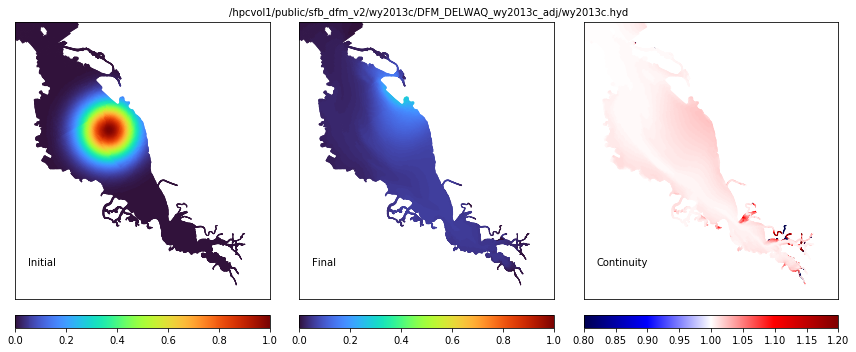

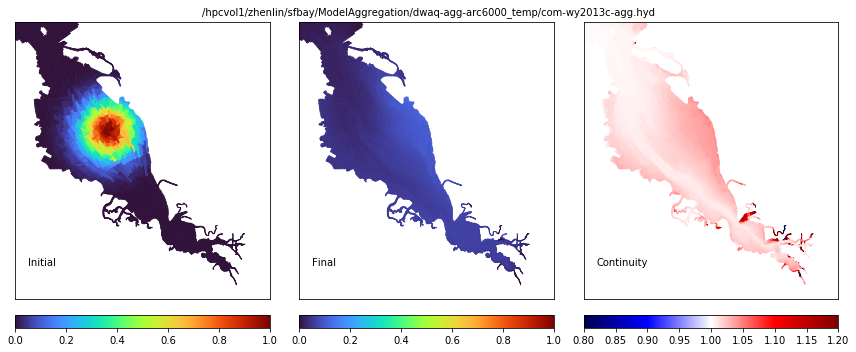

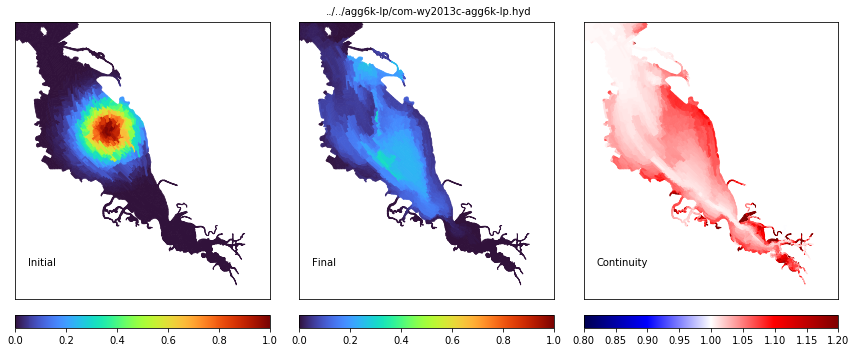

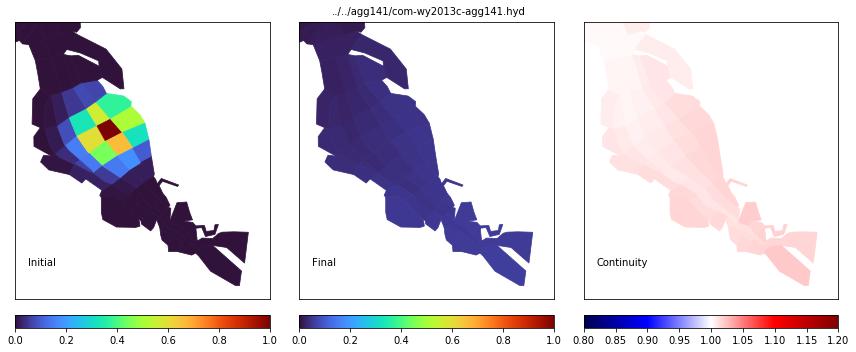

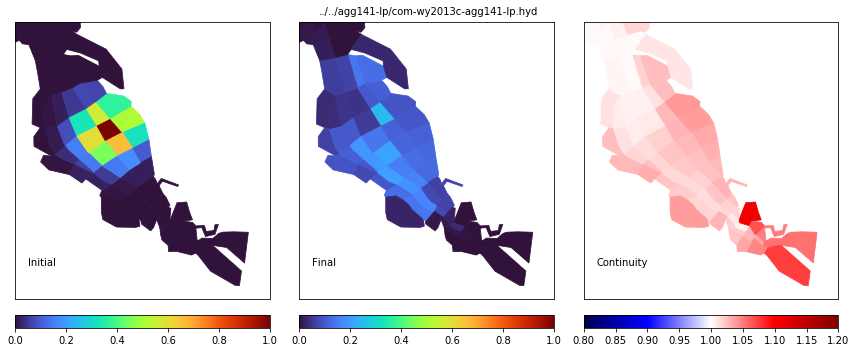

In [53]:
Blobber(hydro=hydro_orig).complete()
Blobber(hydro=hydro_agg6k).complete()
Blobber(hydro=hydro_agg6k_lp).complete()
Blobber(hydro=hydro_agg141).complete()
Blobber(hydro=hydro_agg141_lp).complete()
;

Lower South Bay Blob
==

''

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


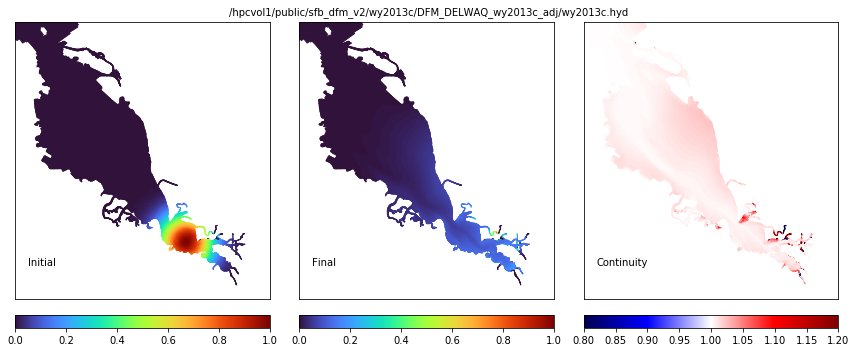

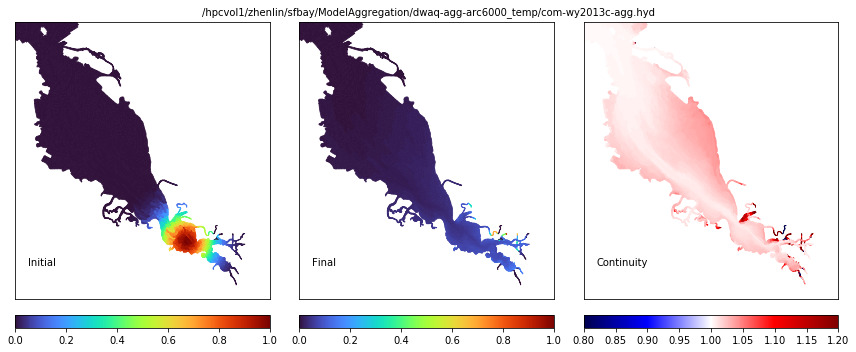

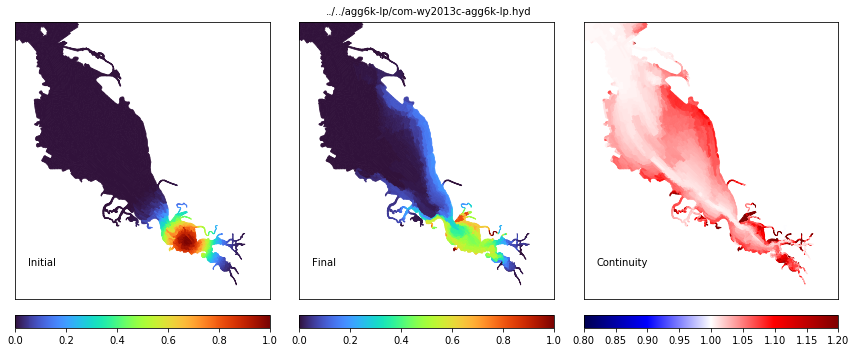

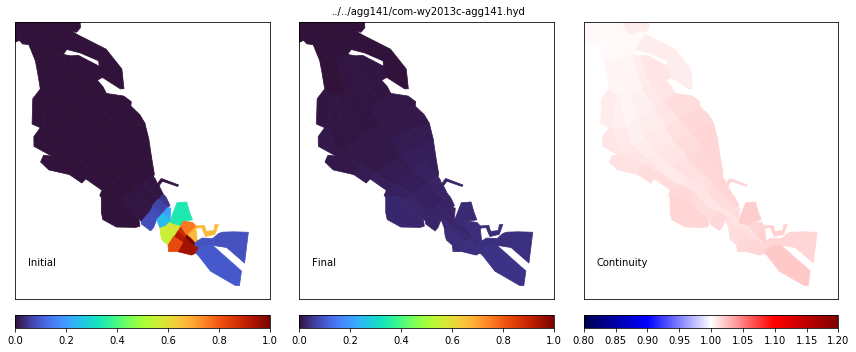

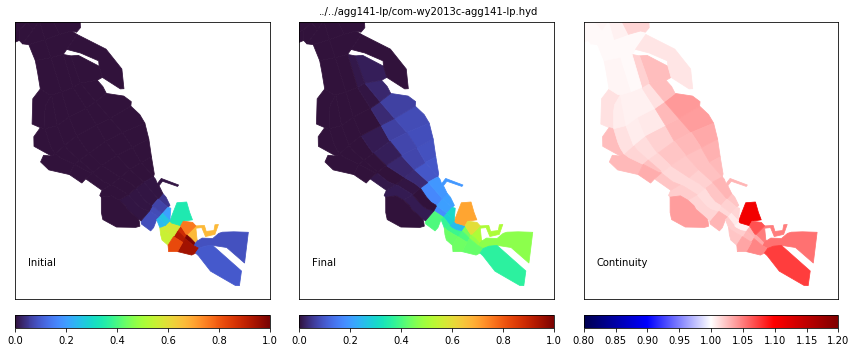

In [54]:
BlobLSB(hydro=hydro_orig).complete()
BlobLSB(hydro=hydro_agg6k).complete()
BlobLSB(hydro=hydro_agg6k_lp).complete()
BlobLSB(hydro=hydro_agg141).complete()
BlobLSB(hydro=hydro_agg141_lp).complete()
;

Time Series of Tracer within a Region
==

These runs initialize a region to a unit concentration, and follow the evolution
of the average tracer concentration in the region as it is flushed out.



In [55]:
class ResidenceTime(Blobber):
    """
    Seed with a regional dye release, include time series plots of mass
    within region.
    """
    # plume parameters
    region=None # shapely.geometry or numpy array [N,2] giving polygon for region.
    blob_name="region" # overwrite this below
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_2panels_and_time()
        return self
    
    def release_conc_2d(self):
        grid=self.hydro.grid()
        
        # Get the region into a shapely geometry
        self.geom=self.region
        if isinstance(self.region,np.ndarray):
            self.geom=geometry.Polygon(self.geom)
            
        c=grid.select_cells_intersecting(self.geom,by_center='centroid')
        c=c.astype(np.float64)
        return c
    
    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d()
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)        
        
    def setup_model(self):
        super(ResidenceTime,self).setup_model()
        self.wm.add_monitor_for_geometry(name='region',geom=self.geom)
        #print("There are now %d monitor areas"%(len(self.wm.monitor_areas)))
        
    def figure_2panels_and_time(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        his_ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_hist.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig=plt.figure(self.fig_num)
        gs=gridspec.GridSpec(1,4)
        
        axs=[fig.add_subplot(gs[:,0]),
             fig.add_subplot(gs[:,1])]
        ax_t=fig.add_subplot(gs[:,2:])
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        for coll in [coll_ic,coll_ec]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs[:2]:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        ax_t.plot(his_ds.time,his_ds.bal.sel(region='region',field='dye1'))
        
        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion

        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
        his_ds.close()

In [56]:
# copied from tally_regions_01.shp
south_bay=wkt.loads("""
Polygon ((570184.11757621716242284 4177639.10577381495386362, 580673.98798651667311788 4165868.02981721935793757, 580779.51211822277400643 4157176.39687086036428809,
                579502.36535809095948935 4152682.20969413500279188, 576316.89153041841927916 4150518.94015444722026587, 574393.47667129873298109 4147040.97573396936058998,
                563137.487071588402614   4149452.58375529991462827, 555436.04330817516893148 4155509.96108419680967927, 551126.1850750622106716  4164827.05031085386872292,
                557692.36349982989486307 4163705.9954578448086977,  563297.63776487542781979 4164746.97496421029791236, 567141.25440376379992813 4167629.68744337651878595,
                568662.68598999048117548 4172033.83150876965373755, 570184.11757621716242284 4177639.10577381495386362))""")

lsb=wkt.loads("""
Polygon ((574393.47667129873298109 4147040.97573396936058998, 576316.89153041841927916 4150518.94015444722026587, 579502.36535809095948935 4152682.20969413500279188, 
                580779.51211822277400643 4157176.39687086036428809, 596208.60523535730317235 4148411.60424893442541361, 593807.15548636857420206 4139647.13588713435456157, 
                590809.89551359775941819 4137600.78393180714920163, 581394.6661063083447516  4139202.93938493076711893, 574187.88490839255973697 4142646.17929060151800513, 
                574393.47667129873298109 4147040.97573396936058998))
""")


southbay_shoal=wkt.loads("""
Polygon ((562839.59208628651686013 4181732.48768383450806141, 570785.53009771392680705 4179192.39274575561285019, 581076.17112890689168125 4164212.34567503165453672, 
          578470.945551389711909   4155680.23190866271033883, 574302.58462736220099032 4156071.01574529008939862, 570785.53009771392680705 4159588.0702749383635819, 
          566291.51597649673931301 4164472.86823278339579701, 564142.20487504510674626 4168966.88235400058329105, 562904.7227257244521752 4173004.98199915187433362, 
          562188.2856919071637094 4177303.60420205537229776, 562839.59208628651686013 4181732.48768383450806141))
""")
#south_bay.union(lsb)

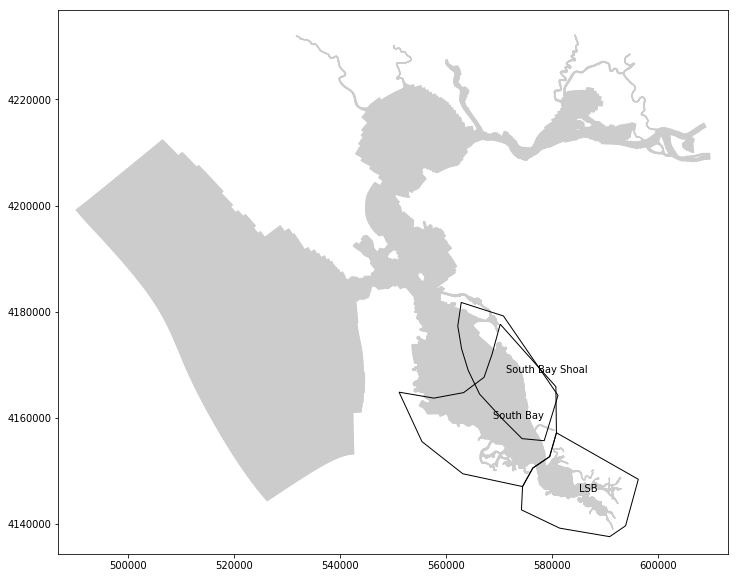

In [57]:
# Show where those regions fall:
fig=plt.figure(figsize=[12,10])
ax=fig.add_subplot(1,1,1)

hydro_orig.grid().plot_cells(color='0.8',ax=ax)
ax.axis('equal')

for poly,name in [ (south_bay,'South Bay'),
                   (lsb,'LSB'),
                   (southbay_shoal,'South Bay Shoal')]:
    plot_wkb.plot_polygon(poly,facecolor='none',ax=ax)
    ax.text(float(poly.centroid.x),
            float(poly.centroid.y),
            name)
    


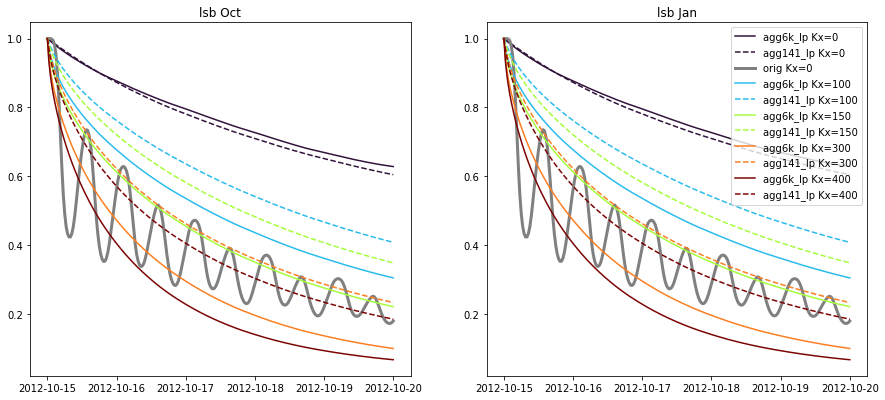

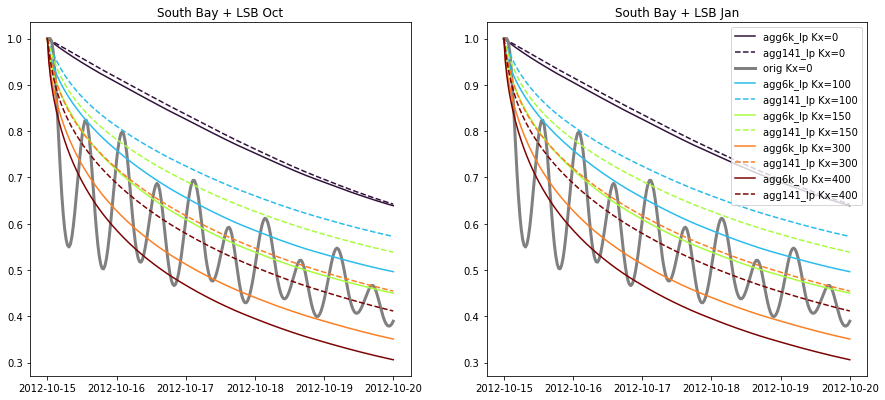

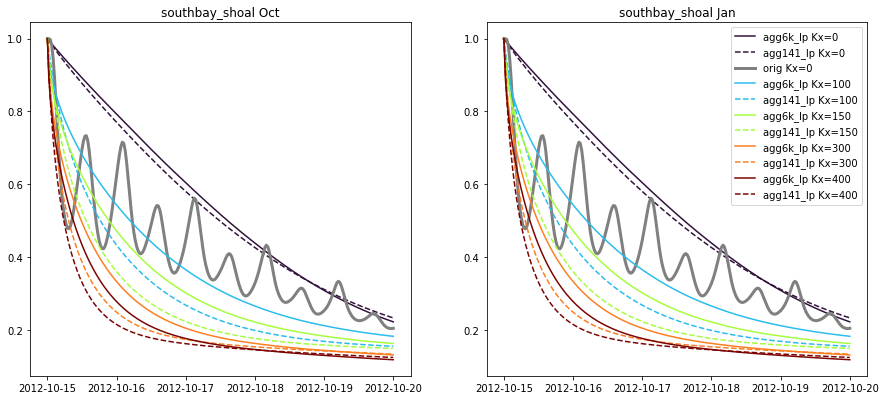

In [74]:
# iterate over different regions, 
# the two base hydro datasets,
# and different global dispersion coefficients

regions=[(lsb,'lsb'),
         (south_bay.union(lsb),'southbay'), # all of South/LSB
         (southbay_shoal,'southbay_shoal')
        ]
# 600 wasn't stable with agg6k_lp.
Kxs=[0,100,150,300,400]


hydros=[hydro_agg6k_lp,hydro_agg141_lp, hydro_orig]

#from matplotlib import cm
#cmap=cm.jet

# some decent Delta flows arrive in December, just trailing off at the start
# of January.
start_periods=[ (np.timedelta64(75,'D'),'Oct'),
                (np.timedelta64(165,'D'),'Jan')]

for region,blob_name in regions:
    # One figure with an axes per time period
    fig,axs=plt.subplots(1,len(start_periods),figsize=[15,6.5])

    for ax,(start_offset,start_name) in zip(axs,start_periods):
        results=[]
        styles=[]

        for Kxi,Kx in enumerate(Kxs):
            color=cmap(float(Kxi)/(len(Kxs)-1.))

            ls=['-','--','-.',':']
            for hydro in hydros:
                if Kx>0 and "orig" in hydro.name:
                    continue # don't bother adding dispersion to original
                log.info("Processing %s"%hydro.name)
                res=ResidenceTime(hydro=hydro,base_x_dispersion=Kx,region=region,blob_name=blob_name)
                res.run_waq_model()
                results.append(res)
                if 'orig' in hydro.name:
                    styles.append( dict(color='0.5',lw=3) )
                else:
                    styles.append( dict(color=color,ls=ls[0]) )
                ls.append(ls.pop(0)) # rotate

        # Plot each one:
        # for res in results:
        #     res.figure_2panels_and_time()

        for res,style in zip(results,styles):
            hist_ds=res.wm.hist_ds()
            ax.plot(hist_ds.time,hist_ds.bal.sel(region='region',field='dye1'),
                    label=res.hydro.name+" Kx=%g"%res.base_x_dispersion,**style)
        if ax==axs[-1]:
            ax.legend()
        if blob_name=='southbay':
            title="South Bay + LSB"
        else:
            title=blob_name
        title+= " " + start_name
        ax.set_title(title) 

Results so far
==

Filtering is effective at decreasing dispersion to levels below the high resolution run.

Global dispersion coefficients in the range of 200 m$^2$/s match the non-tidal aggregated runs to the tidal resolved model.

The ideal dispersion coefficient differs between the aggregation geometries, and between the target region.

Next Steps
==

1. Try biogeochemical runs with one of the promising configurations from above.
2. Refine the aggregation/filtering/dispersion.

Refining
-- 

1. What are effective ways of evaluating the configurations?
  - residence time (and over what regions?)
  - spatial distribution of a continuous source
  - fluxes, other?
2. Promising aspects to tune?
  - spatially varying $K$
  - time-varying $K$ at seasonal, spring-neap time scales.
  - directional $K$

In [78]:
# This doesn't work yet.
class OutfallPlume(Blobber):
    """
    Extend to adding continous sources
    """
    
    # set length of the run
    duration=np.timedelta64(5,'D')
    blob_name='sbOutfall' 
    
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_3panels()
        return self # makes for more compact iteration loops later
        
    def setup_tracers(self):
        # boundary condition will default to 0.0
        self.wm.substances['dye1']=dwaq.Substance(initial=0.0)
        elt=self.hydro.grid().select_cells_nearest(self.X0)
        discharge=self.wm.add_discharge(element=elt,k=0)
        self.wm_add_load([discharge],['dye1'],100.0)
        
    def figure_3panels(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,2,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        for coll in [coll_ic,coll_ec]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

In [77]:
# Broken -- need to see what happened to segment_select.

#OutfallPlume(hydro=hydro_agg141_lp).complete()